## Closed-Form Solutions for Robust Acoustic Sensor Localization
##### Bruno Granato
##### Carolina Bez
##### Eduardo Alves
##### Fabiana Fonseca
##### Pedro Lisboa

##### ***Processamento de Sinais de Áudio - 2019.1***
##### ***Escola Politécnica - Universidade Federal do Rio de Janeiro***

---

#### Replicação dos resultados encontrados nas simulações de: 
#### Haddad, Diego & Nunes, Leonardo & Martins, Wallace & Biscainho, Luiz & Lee, Bowon. (2013). Closed-Form Solutions for Robust Acoustic Sensor Localization. 


### Sumário
___

- [Config](#config)
- [Métodos TOF](#tof)
    - [T](#t)
    - [Ta](#ta)
    - [Tab](#tab)
- [Métodos TDOF](#tdof)
- [Simulação I](#sim1)
- [Simulação II](#sim2)
- [Simulação III](#sim3)
- [Simulação IV](#sim4)

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import os
import joblib as jbl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from functions import get_error_magnitude

sns.set_style('whitegrid')
%matplotlib inline

### Config <a name=config></a>

In [136]:
space_dim = 3
n_loudspeakers = 12
n_microphones = 1000
room_dim = np.array([5.2, 7.5, 2.6])
c = 340 # speed of sound
sensor_file = 'sensor_positions.jbl'
source_file = 'source_positions.jbl'

if os.path.exists(sensor_file):
    ls_pos = jbl.load(sensor_file)
else:
    ls_pos = room_dim * np.random.rand(n_loudspeakers, space_dim)

if os.path.exists(source_file):
    mp_pos = jbl.load(source_file)
else:
    mp_pos = room_dim * np.random.rand(n_microphones, space_dim)

## Métodos TOF <a name="tof"></a>

In [116]:
def solve(H,g):
    H_t = np.transpose(H)
    H_inv = np.linalg.inv(H_t @ H)

    sol = np.dot(H_inv @ H_t, g) 
    return sol

### T solution <a name=t></a>

\begin{equation*}
e_{(T)} =  \begin{bmatrix}
1 & -2s_1^{T} \\
\vdots &\vdots \\
1 & -2s_1^{T}
\end{bmatrix}
\begin{bmatrix}
 ||\textbf{m}||^2 \\
 \textbf{m} 
\end{bmatrix} - 
\begin{bmatrix}
-||s_1||^2 + c^2\hat{t}_1^2 \\
\vdots  \\
-||s_S||^2 + c^2\hat{t}_S^2
\end{bmatrix}
\end{equation*}

In [117]:
def tof_t(t_hat, ls_pos):
    ## generate matrix H
    n_loudspeakers = ls_pos.shape[0]
    H = np.concatenate([np.ones((n_loudspeakers, 1), dtype=np.float64),
                        -2*ls_pos], axis=1)
    g = -np.linalg.norm(ls_pos, ord=2, axis=1)**2 + (c**2)*t_hat**2
    
    return solve(H,g)

### Ta solution <a name=ta></a>

\begin{equation*}
e_{(T)} =  \begin{bmatrix}
1 & -2s_1^{T} & \hat{t}_1^2\\
\vdots &\vdots &\vdots \\
1 & -2s_1^{T} & \hat{t}_S^2
\end{bmatrix}
\begin{bmatrix}
 ||\textbf{m}||^2 \\
 \textbf{m} \\
 a^2
\end{bmatrix} - 
\begin{bmatrix}
-||s_1||^2 \\
\vdots  \\
-||s_S||^2
\end{bmatrix}
\end{equation*}

In [118]:
def tof_ta(t_hat, ls_pos):
    ## generate matrix H
    n_loudspeakers = ls_pos.shape[0]
    t_hat = t_hat.reshape((t_hat.shape[0], 1))
    H = np.concatenate([np.ones((n_loudspeakers, 1), dtype=np.float64),
                        -2*ls_pos, -t_hat**2], axis=1)
    g = -np.linalg.norm(ls_pos, ord=2, axis=1)**2
    return solve(H,g)

### Tab solution <a name=ta></a>

\begin{equation*}
e_{(T)} =  \begin{bmatrix}
1 & -2s_1^{T} & \hat{t}_1^2 & -2\hat{t}_1\\
\vdots &\vdots &\vdots &\vdots \\
1 & -2s_1^{T} & \hat{t}_S^2 & -2\hat{t}_S
\end{bmatrix}
\begin{bmatrix}
 ||\textbf{m}||^2 \\
 \textbf{m} \\
 a^2 \\
 ab
\end{bmatrix} - 
\begin{bmatrix}
-||s_1||^2 \\
\vdots  \\
-||s_S||^2
\end{bmatrix}
\end{equation*}

In [119]:
def tof_tab(t_hat, ls_pos):
    ## generate matrix H
    n_loudspeakers = ls_pos.shape[0]
    t_hat = t_hat.reshape((t_hat.shape[0], 1))
    H = np.concatenate([np.ones((n_loudspeakers, 1), dtype=np.float64),
                        -2*ls_pos, -(c**2)*t_hat**2, -2*t_hat], axis=1)
    g = -np.linalg.norm(ls_pos, ord=2, axis=1)**2
    return solve(H,g)

### Simulação I <a name=sim1></a>

In [120]:
def run_simulation_one(mp_pos, ls_pos, scale, c):
    # distance between source and microphone 
    distance = np.apply_along_axis(lambda s: mp_pos - s,axis=1, arr=ls_pos) 
    t_hat_array = np.linalg.norm(distance, ord=2, axis=2) / c
    noise_array = np.random.normal(loc=0, scale=scale, size=(n_loudspeakers,n_microphones))
    t_hat_array += noise_array
    solT = np.apply_along_axis(lambda t_hat: tof_t(t_hat, ls_pos),
                              axis=0, arr=t_hat_array)
    solTa = np.apply_along_axis(lambda t_hat: tof_ta(t_hat, ls_pos),
                              axis=0, arr=t_hat_array)
    solTab = np.apply_along_axis(lambda t_hat: tof_tab(t_hat, ls_pos),
                              axis=0, arr=t_hat_array)
    
    return {'T' : solT[1:,:], 
            'Ta': solTa[1:4,:],
            'Tab': solTab[1:4,:]}

In [125]:
std_range_cm = np.arange(0,6)
std_range = std_range_cm / (c*100)
estimated_parameters = {scale:run_simulation_one(mp_pos, ls_pos, scale, c) 
                        for scale in std_range}
results = get_error_magnitude(estimated_parameters, mp_pos)

# Flattening results dictionary for multiindex parsing on pandas
results = {(method, scale) : value   
            for scale, res in results.items()
            for method, value in res.items()}
results = pd.DataFrame(results)

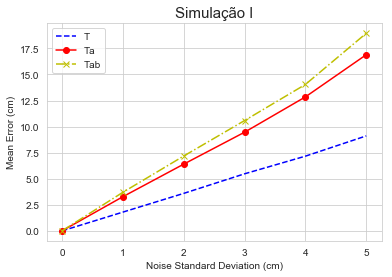

In [137]:
import seaborn as sns
results.columns = results.columns.set_names(['Method', 'Noise'], level=[0,1])
mean_errors = results.mean()
mean_errors = mean_errors.reset_index()
mean_errors.columns = ['Method', 'Noise', 'Mean Error']
mean_errors['Noise'] = 100 * c *mean_errors['Noise'] 
mean_errors['Mean Error'] = 100 * mean_errors['Mean Error'] 
fig, ax = plt.subplots()

markers = ['', 'o', 'x', '+']
linestyles=['--', '-', '-.']
colors=['b', 'r', 'y', 'g']
for i, (g_name, g) in enumerate(mean_errors.groupby('Method')):
    ax.plot(g['Noise'], g['Mean Error'], label=g_name, 
            linestyle=linestyles[i], marker=markers[i], color=colors[i])
ax.set_ylabel('Mean Error (cm)')
ax.set_xlabel('Noise Standard Deviation (cm)')
ax.set_title('Simulação I', fontsize=15)
plt.legend();